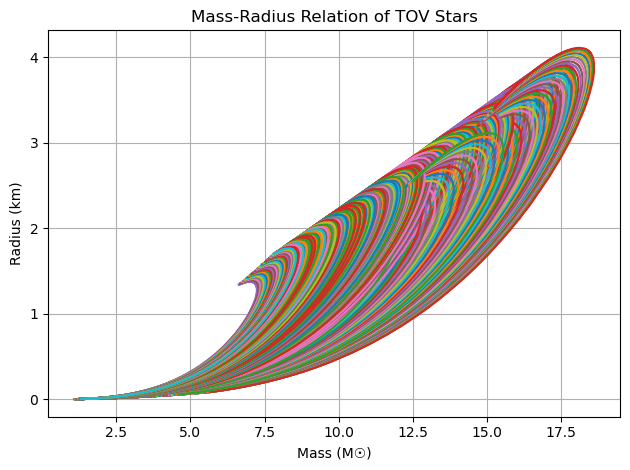

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

# List of folders to search
folders = ['TOV_results_Quark_Stars_part1', 'TOV_results_Quark_Stars_part2']
pattern = '*.csv'

# Loop through each folder and collect matching CSV files
for folder in folders:
    if not os.path.exists(folder):
        continue  # Skip missing folders

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files:
        filepath = os.path.join(folder, file)
        
        # Load CSV data, skipping header
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 2:
            continue  # Skip malformed or incomplete files

        # Plot Mass vs Radius
        plt.plot(data[:, 1], data[:, 0], label=f"{folder}/{file.split('.')[0]}")

# Final plot formatting
plt.xlabel("Mass (M☉)")
plt.ylabel("Radius (km)")
plt.title("Mass-Radius Relation of TOV Stars")
plt.grid(True)
plt.tight_layout()
plt.show()
